In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchaudio

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 6.7MB 38.3MB/s 


# Flags

In [2]:
PERSIAN_FLAG = True
SEQ2SEQ_Training = False

# Dataset

## Text transform class

In [3]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
from tqdm.auto import tqdm

class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        > 28
        < 29
        """
        if PERSIAN_FLAG:
          char_map_str = """
          = 0
          o 1 
          l 2 
          g 3
          e 4
          t 5
          p 6
          / 7
          z 8
          ] 9
          v 10
          j 11
          m 12
          x 13
          s 14
          q 15
          r 16
          a 17
          [ 18
          d 19
          , 20
          ' 21
          f 22
          y 23
          b 24
          <SPACE> 25
          k 26
          n 27
          h 28
          u 29
          . 30
          i 31
          > 32
          < 33
          """

        self.start_token = '<'
        self.stop_token = '>'
        self.pad_token = '=' if PERSIAN_FLAG else "'"

        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        if PERSIAN_FLAG:
          self.index_map[25] = ' '
        else:
          self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

if PERSIAN_FLAG:
  sample_rate = 16000
else:
  sample_rate = 22050

train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

## Collate function

In [4]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    waveforms = []

    for (waveform, _, utterance, _, _, _) in data:

        waveforms.append (waveform)

        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        
        spectrograms.append(spec)
        utterance = '<' + utterance + '>'
        
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)

        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3) 
    # n_batch , n_channels = 1, n_feats = 128 , n_seq = variable and equal to longest waveform in batch

    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    # n_batch, n_seq = variable and equal to longest utterance in batch
    
    return waveforms, spectrograms, labels, input_lengths, label_lengths


## Dataset class

In [5]:
from scipy.io import wavfile
import os
from tqdm.auto import tqdm
import numpy as np
import glob
import torch


class FarsDot(torch.utils.data.Dataset):
    def __init__(self, data_set):
        self.dataset = data_set
        
    def __getitem__(self, index):
        waveform = torch.tensor (self.dataset[index]['data'], dtype = torch.float32)
        utterance = self.dataset[index]['text']
        return (
        waveform,
        _,
        utterance,
        _,
        _,
        _,
    )

    def __len__(self):        
        return len (self.dataset)
    
def extract_samples(path = "CD2/" , max_limit = 30):

    
    wave_files = os.listdir(path + "wave/")

    waves = []

    print ("reading audio files ... ")
    count = 0
    for wave_file in tqdm (wave_files):
    
        fs, data = wavfile.read(path + "wave/" + wave_file)
        data = data/np.max([np.abs (data.max()), np.abs (data.min())])
        assert fs == 22050
    
        sentences = []
        with open(path + "SENTENCE/" + wave_file.split('.')[0] + '.SNT' , 'r') as sentence_file:
            for line in sentence_file:
                sentences.append (line)
    
        waves.append ({'data':data, 'id':int (wave_file.split('.')[0][1:]) , 'sentences':sentences})
        
        count += 1
        if max_limit is not None and count > max_limit:
            break
    
    samples = []
    letters_dictionary = []

    corpus = []
    print ("parsing sentences ... ")
    for wave in tqdm (waves):
        for line in wave['sentences']:
            sent_id , start, stop = line.split ()
            sent_id = int (sent_id)
            start = int (start) // 2
            stop = int (stop) // 2

            text = []
            with open (path + 'WORD/W' + str(wave['id']) + '.' + str(sent_id), 'r') as f:
                for l in f:
                    text.append (l.split()[0])
            # text = text[1:] #ignoring first j

            text = ' '.join(text)
            
            for t in text:
                if t not in letters_dictionary:
                    letters_dictionary.append (t)

            samples.append ({'data':wave['data'][start:stop] , 'file_id':wave['id'] , 'sentence_id':sent_id, 'text':text} )
            
            corpus.append (text)
    
    with open ("corpus.txt" , 'w') as f:
      for s in corpus:
          f.write("%s\n" % s)
        
    
    letters_dictionary = set (letters_dictionary)
        
    return samples , letters_dictionary

## Load dataset from disk

In [6]:
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
def permute_split_dataset (full_dataset, test_ratio):

    torch.manual_seed(42)
    np.random.seed(42)
    
    perm_indices = np.random.permutation(len (full_dataset))
    eval_dataset = [v for j,v in enumerate (full_dataset) if j in perm_indices [:int (test_ratio * len(full_dataset))]]
    train_phase_dataset = [v for j,v in enumerate (full_dataset) if j not in perm_indices [:int (test_ratio * len(full_dataset))]]
    return train_phase_dataset, eval_dataset

if PERSIAN_FLAG:
  # s1 , l1 = extract_samples(path = "/content/drive/My Drive/ASR/CD1/" , max_limit = None)
  # s2 , l2 = extract_samples(path = "/content/drive/My Drive/ASR/CD2/" , max_limit = None)

  # with open("/content/drive/My Drive/ASR/cd1.dat", 'wb') as f:
  #   torch.save(s1, f)
  # with open("/content/drive/My Drive/ASR/cd2.dat", 'wb') as f:
  #   torch.save(s2, f)

  with open("/content/drive/My Drive/ASR/cd1.dat", 'rb') as f:
    s1 = torch.load(f)
  with open("/content/drive/My Drive/ASR/cd2.dat", 'rb') as f:
    s2 = torch.load(f)
  
  total_dataset = s1 + s2
  #fixme
  train_dataset, test_dataset = permute_split_dataset(total_dataset , 0.2)

  train_dataset = FarsDot(train_dataset)
  test_dataset = FarsDot(test_dataset)

else:
  if not os.path.isdir("./data"):
    os.makedirs("./data")

  train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
  # train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)
  test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

## Dataloader

In [8]:

train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=10,
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'train'),
                            num_workers= 4, pin_memory= True)

test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=10,
                            shuffle=True,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            num_workers= 4, pin_memory= True)


In [10]:
a = next (iter (train_loader))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/python

# Language Model

In [11]:
USE_LM_Model = True

In [12]:
def generate_text_corpus(train_dataset):
  text_corpus = []
  for _,_,utterance,_,_,_ in train_dataset:
    text_corpus.append (text_transform.start_token + utterance + text_transform.stop_token)
  return text_corpus
text_corpus = generate_text_corpus(train_dataset)

In [13]:
def LM_collate_fn(batch):
    labels = []
    for utterance in batch:
      label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
      labels.append(label)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=False) 
    return labels

LM_train_loader = data.DataLoader(dataset = text_corpus,
                            batch_size=10,
                            shuffle = True,
                            collate_fn = LM_collate_fn,
                            num_workers= 4, pin_memory= True)


a = next (iter (LM_train_loader))

print (a.shape)

torch.Size([98, 10])


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


## LM model

In [14]:
class LangualeModel(nn.Module):
  def __init__(self):
    super(LangualeModel, self).__init__()
    if PERSIAN_FLAG:
      n_class = 32 + 2 + 1# +2 for start and stop tokens , +1 for pad token
    else:
      n_class = 29 + 2 # +2 for start and stop tokens

    self.vocab_size = n_class
    self.embeding_size = 100
    self.hidden_size = 512
    self.embedding = torch.nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embeding_size, padding_idx=text_transform.char_map [text_transform.pad_token])
    self.rnn = nn.LSTM(input_size = self.embeding_size, hidden_size = self.hidden_size, num_layers = 1, bias = True, batch_first = False)
    self.output_projection = nn.Linear (self.hidden_size, self.vocab_size , bias=False)

  def get_logits(self, sent, init_hidden_states = None):
    DEVICE = next (self.parameters()).device
    batch_size = sent.shape[1]
    if init_hidden_states is None:
      init_hidden_states = [torch.zeros ([1,batch_size, self.hidden_size] , requires_grad = False).to(DEVICE),
                                  torch.zeros ([1,batch_size, self.hidden_size] , requires_grad = False).to(DEVICE)]
    embedded_sents = self.embedding (sent)
    output, last_hidden = self.rnn(embedded_sents, init_hidden_states)
    logits = self.output_projection (output)
    return logits, last_hidden

  def forward(self,full_sentences):
    full_sentences = full_sentences.long()
    sent = full_sentences[:-1]
    logits, _ = self.get_logits(sent)
    
    sent_mask = (full_sentences != 0).float()    
    log_probs = F.log_softmax(logits, dim=-1)
    # Compute log probability of generating true target words
    tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]
    scores = tgt_gold_words_log_prob.sum(dim=0)
    
    return scores


In [15]:
if USE_LM_Model:
  LM_model = LangualeModel().cuda()
  optimizer = optim.Adam(LM_model.parameters(), 5e-4)


In [16]:
if USE_LM_Model:
  print ("Training LM model, be patient...")
  for epoch in tqdm (range (5)):
    loss_avg = 0
    n_batch = 0
    for batch in tqdm (LM_train_loader):
      optimizer.zero_grad()
      batch_size = len (batch)
      scores = LM_model (batch.cuda())
      loss = -scores.sum()/batch_size
      loss.backward()
      optimizer.step()
      loss_avg = (loss.item() * batch_size + loss_avg * n_batch) / (batch_size + n_batch) 
    print ("average loss :" , loss_avg)

Training LM model, be patient...



average loss : 5.386420726776123



average loss : 0.6910830736160278



average loss : 0.8549004197120667



average loss : 0.6195633411407471



average loss : 0.7709226012229919



# Models

## CTC-Based model

In [17]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):

    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

## Seq2Seq Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class AttnDecoder(nn.Module):
    def __init__(self, hidden_size: int, embed_size: int, tgt_vocab_size: int, dropout_rate=0.2):
        """
        hidden_size: hidden size to be used for the RNN
        embed_size: embedding size (dimension)
        tgt_vocab_size: target language vocab size 
        dropout_rate: rate to be used for the dropout layer 
        """
        super(AttnDecoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.tgt_vocab_size = tgt_vocab_size
        self.rnn = None
        self.dropout = None
        self.tgt_vocab_projection = None  
        self.attn_combine = None 
        self.tgt_embedding = None
        self.text_transform = text_transform
        self.tgt_embedding = torch.nn.Embedding(num_embeddings = self.tgt_vocab_size, embedding_dim = self.embed_size
                                                , padding_idx=self.text_transform.char_map [self.text_transform.pad_token])
        self.rnn = torch.nn.GRUCell(input_size = self.embed_size + self.hidden_size, hidden_size = self.hidden_size)# bias=False)

        self.attn_combine = torch.nn.Linear( 2 * hidden_size, hidden_size, bias=False)
        self.tgt_vocab_projection = torch.nn.Linear(hidden_size, self.tgt_vocab_size, bias=False)
        self.dropout = torch.nn.Dropout (dropout_rate)
    
    def get_logits(self, enc_hiddens, enc_hiddens_mask, tgt, dec_init_state, combined_output_prev = None):
        dec_state = dec_init_state
        batch_size = enc_hiddens.size(0)
        DEVICE = next(self.parameters()).device
        if combined_output_prev is None:
            combined_output_prev = torch.zeros(batch_size, self.hidden_size, device=DEVICE)
        combined_outputs = []
        embeded_target = self.tgt_embedding (tgt)
        for t, y_t in enumerate (embeded_target):
          ybar_t = torch.cat ((y_t, combined_output_prev) , dim = -1)
          dec_state , combined_output_prev = self.step(ybar_t , dec_state, enc_hiddens, enc_hiddens_mask)
          combined_outputs.append (combined_output_prev)
        combined_outputs = torch.stack (combined_outputs)
        projected = self.tgt_vocab_projection (combined_outputs)
        logits = projected

        return logits, dec_state, combined_output_prev

    
    def forward(self, enc_hiddens: torch.Tensor, enc_hiddens_mask: torch.Tensor, 
                tgt: torch.Tensor, dec_init_state: torch.Tensor = None, combined_output_prev = None):        
        tgt = tgt[:-1]
        logits, _, _ = self.get_logits(enc_hiddens, enc_hiddens_mask, tgt, dec_init_state, combined_output_prev)
        return logits

        
    def step(self, ybar_t: torch.Tensor, dec_state: torch.Tensor, enc_hiddens: torch.Tensor, enc_hiddens_mask):
        """
        ybar_t: the input to be fed to the decoder at the current step with shape
        dec_state: decodor's previous hidden state 
        enc_hiddens: encoder hidden states (outputs)
        enc_hiddens_mask: mask generated during the encoding phase that masks <PAD>s 

        returns the current hidden state and combined output
        """
        attn_scores_t, dec_state_t = None, None
        
        dec_state_t = self.rnn(ybar_t,dec_state)
        # print ("enc_hiddens.shape:", enc_hiddens.shape, "dec_state_t.unsqueeze(-1).shape", dec_state_t.unsqueeze(-1).shape)
        attn_scores_t = torch.bmm (enc_hiddens , dec_state_t.unsqueeze(-1)).squeeze(-1)

        if enc_hiddens_mask is not None:
            attn_scores_t.data.masked_fill_(enc_hiddens_mask.bool(), -float('inf'))

        combined_output_t = None
        
        atten_dist = torch.nn.Softmax(dim=-1)(attn_scores_t)

        
        context_vector = enc_hiddens * atten_dist[:,:,None]
        context_vector = context_vector.sum(dim = 1)
        
        concated_tensor = torch.cat((dec_state_t, context_vector) , dim = -1)
        combined_output_t = self.dropout (torch.tanh(self.attn_combine (concated_tensor)))
        
        return dec_state_t, combined_output_t


class Seq2Seq_SpeechRecognitionModel(nn.Module):
    
    def generate_enc_hiddens_mask(self, enc_hiddens, lengths):
        """Generates mask which masks the encoder hidden states corresponding to <PAD> tokens 
        in the source sentences
        """
        DEVICE = next (self.parameters()).device
        enc_masks = torch.zeros(enc_hiddens.shape[0], enc_hiddens.size(1), dtype=torch.float)
        for iterator, length in enumerate(lengths):
            enc_masks[iterator, length:] = 1

        return enc_masks.to(DEVICE)
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(Seq2Seq_SpeechRecognitionModel, self).__init__()
        
        self.encoder_hidden_size = 512
        self.decoder_hidden_size = 512
        self.encoder_gru = torch.nn.GRU(input_size  = n_feats , hidden_size = self.encoder_hidden_size, num_layers = 2, bidirectional = True)
        
        self.bridge = nn.Linear(self.encoder_hidden_size * 2, self.decoder_hidden_size, bias = False)
        self.decoder = AttnDecoder(hidden_size = self.decoder_hidden_size, embed_size = 100, tgt_vocab_size = n_class) 
        self.text_transform = text_transform
        
    def encoder(self,x,input_lengths):
        x = x[:,0].permute([2,0,1])
        batch_size = x.shape[1]
        seq_len = x.shape[0]
        
        enc_hiddens, last_hiddens = self.encoder_gru(x)
        last_hiddens = last_hiddens.reshape([2, 2, batch_size, self.encoder_hidden_size])
        last_hiddens = last_hiddens[-1].permute ([1,0,2])
        last_hiddens = last_hiddens.reshape([batch_size, 2*self.encoder_hidden_size])
        
        enc_hiddens = enc_hiddens.reshape([seq_len, batch_size, 2 , self.encoder_hidden_size])
        enc_hiddens = enc_hiddens[::2,:,1,:]
        enc_masks = self.generate_enc_hiddens_mask(enc_hiddens, input_lengths)
        enc_hiddens = enc_hiddens.permute ([1,0,2])
        enc_masks = enc_masks.permute ([1,0])

        return enc_hiddens, last_hiddens, enc_masks
    
    def forward(self, x, labels, input_lengths):
        enc_hiddens, last_hiddens, enc_masks = self.encoder (x, input_lengths)
        
        init_hiddens = self.bridge(last_hiddens)
        
        tgt_tensor = labels.permute([1,0]).long() #time, batch
        logits = self.decoder(enc_hiddens = enc_hiddens, enc_hiddens_mask = enc_masks, tgt= tgt_tensor, dec_init_state = init_hiddens, combined_output_prev = None)
        
        log_probs = F.log_softmax(logits, dim=-1)
        tgt_mask = (tgt_tensor != 0).float()
        tgt_gold_words_log_prob = torch.gather(log_probs, index=tgt_tensor[1:].unsqueeze(-1), dim=-1).squeeze(-1) * tgt_mask[1:]
        scores = tgt_gold_words_log_prob.sum(dim=0)

        return scores            

    def decode_one_beam(self, beam, enc_hiddens, enc_masks, k):
        DEVICE = next(self.parameters()).device
        token = torch.tensor ([beam['tokens'][-1]])
        sentences = token[None].to(DEVICE)
        
        logits, hidden_state, combined_out_prev = self.decoder.get_logits(enc_hiddens, enc_masks, sentences,
                                                                          dec_init_state = beam['last_hidden'], combined_output_prev = beam['combined_out_prev'])
        
        probs = logits.softmax(dim=-1)

        LM_hiddens = None
        if USE_LM_Model:
          LM_hiddens = beam['LM_init_hidden']
          lm_logits, LM_hiddens = LM_model.get_logits(sentences, LM_hiddens)
          lm_probs = logits.softmax(dim=-1)
          probs = probs * lm_probs

        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])

        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "combined_out_prev":combined_out_prev, "LM_init_hidden":LM_hiddens, 
                        "prob": probs[i].log().item() + beam['prob'] , "tokens": beam['tokens']+[idxs[i].item()]})        
        return res


                    
    def BeamDecode_one_data (self, spectrogram, input_length, max_length = 50, k = 5):
      DEVICE = next (self.parameters()).device
      enc_hiddens, last_hiddens, enc_masks = self.encoder (spectrogram[None], [input_length])
      token = text_transform.text_to_int (self.text_transform.start_token)[0]
      
      beams_queue = [{"tokens": [token], "prob": 0, "last_hidden": self.bridge(last_hiddens), "combined_out_prev":None, "LM_init_hidden" : None}]
      
      completed_beams = []
      beam_size = k
  
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_one_beam (beam, enc_hiddens, enc_masks, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        next_beams_queue = []
        for j in range(len(beams_queue)):
          if not (beams_queue[j]['tokens'][-1] == text_transform.text_to_int (text_transform.stop_token)[0]):
            next_beams_queue.append (beams_queue[j])
          else:
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            
        beams_queue = next_beams_queue
            
        if (beam_size <= 0):
            break
    
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
            
      tokens_list = max(completed_beams, key=lambda x: x['prob'])['tokens']
      
      return "".join (text_transform.int_to_text(tokens_list))

    def beam_decode(self, spectrograms, input_lengths, max_length = 50, k = 5):
        decoded_batch = []
        for j in range (len (spectrograms)):
            decoded_batch.append (self.BeamDecode_one_data(spectrograms[j], input_lengths[j], max_length, k))
        return decoded_batch
            
                  
    def greedy_decode(self, spectrograms, input_lengths, max_length = 50):
        DEVICE = next (self.parameters()).device
        decoded_batch = []
        for j in range (len (spectrograms)):
            enc_hiddens, last_hiddens, enc_masks = self.encoder (spectrograms[j][None], [input_lengths[j]])
            init_hiddens = self.bridge(last_hiddens)
            
            labels = []
            
            dec_state = init_hiddens
            token = self.text_transform.start_token
            labels.append(token)
            
            combined_output_prev = torch.zeros(1, self.decoder.hidden_size, device=DEVICE)

            for i in range (max_length):
                token = torch.tensor (self.text_transform.text_to_int (token)).to(DEVICE)
                embeded_token = self.decoder.tgt_embedding (token)
                ybar_t = torch.cat ((embeded_token, combined_output_prev) , dim = -1)

                dec_state , combined_output_prev = self.decoder.step(ybar_t , dec_state, enc_hiddens, enc_masks)
                projected = self.decoder.tgt_vocab_projection (combined_output_prev)
                token = self.text_transform.int_to_text ([torch.argmax(projected).item()])[0]
#                 print (token)
                labels.append(token)
                if token == text_transform.stop_token:
                    break            
            decoded_batch.append ("".join (labels))
            
        
        
        return decoded_batch 
    

        

## Model instatnciation , Optimizer, Scheduler

In [19]:
device = torch.device("cuda")
epochs = 40
if PERSIAN_FLAG:
  n_class = 32 + 2 + 1# +2 for start and stop tokens , +1 for pad token
else:
  n_class = 29 + 2 # +2 for start and stop tokens

if SEQ2SEQ_Training:
  n_class -= 1

if SEQ2SEQ_Training:
  model = Seq2Seq_SpeechRecognitionModel (n_cnn_layers = 3, n_rnn_layers = 5, rnn_dim = 512, n_class = n_class , n_feats = 128, stride = 2, dropout = 0.1).to(device)
else:
  model = SpeechRecognitionModel (n_cnn_layers = 3, n_rnn_layers = 5, rnn_dim = 1024, n_class = n_class , n_feats = 128, stride = 2, dropout = 0.1).to(device)


if PERSIAN_FLAG:
  criterion = nn.CTCLoss(blank=31 + 2 + 1).to(device)
else:
  criterion = nn.CTCLoss(blank=28 + 2).to(device)
if SEQ2SEQ_Training:
  optimizer = optim.AdamW(model.parameters(), 7e-4)  
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma=0.95, last_epoch=-1)  
else:
  optimizer = optim.AdamW(model.parameters(), 5e-4)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=5e-4, 
                                          steps_per_epoch=int(len(train_loader)),
                                          epochs=epochs,
                                          anneal_strategy='linear')

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [20]:
get_lr(optimizer)

2e-05

## Model debug

In [21]:
debug_model = True
if debug_model:
  
  for batch_idx, _data in enumerate(train_loader):
      waveforms, spectrograms, labels, input_lengths, label_lengths = _data 
      spectrograms, labels = spectrograms.to(device), labels.to(device)
      if batch_idx > 4:
        break
  with open("sample_data.pth" , 'wb') as f:
    torch.save ([waveforms, spectrograms, labels, input_lengths, label_lengths] , f)

  print (spectrograms.shape)
  print (labels.shape)
  print (input_lengths)
  if SEQ2SEQ_Training:
    p = model (spectrograms, labels, input_lengths)
    loss = -p/spectrograms.shape[0]
    print ("decoded:", model.beam_decode(spectrograms, input_lengths))
  else:
    p = model (spectrograms).transpose(0, 1) 
    loss = criterion(p, labels, input_lengths, label_lengths)
  print ("loss:" , loss)
  print (p.shape)
  del spectrograms, _data, waveforms
  torch.cuda.empty_cache()

torch.Size([10, 1, 128, 473])
torch.Size([10, 56])
[149, 180, 159, 135, 89, 96, 171, 122, 236, 111]
loss: tensor(-3.2576, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([237, 10, 35])


# Metrics and Decoders



In [22]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer



def GreedyDecoder(output, labels, label_lengths, blank_label=(31 + 2 + 1) if PERSIAN_FLAG else (28+2), collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

def SEQ2SEQ_Decoder(spectrograms, model, labels, label_lengths, input_lengths):

	# decodes = model.greedy_decode(spectrograms, input_lengths)
  decodes = model.beam_decode(spectrograms, input_lengths)
  targets = []
  for i, args in enumerate(spectrograms):
    decode = []
    targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
  return decodes, targets


# Train and Valid

In [23]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch , writer, limit = None, loss_tracker = []):
  model.train()
  data_len = 0

  loss_avg = 0
  
  for batch_idx, _data in tqdm (enumerate(train_loader) , total = len (train_loader)):
      waveforms, spectrograms, labels, input_lengths, label_lengths = _data 
      spectrograms, labels = spectrograms.to(device), labels.to(device)
      batch_size = len (spectrograms)

      optimizer.zero_grad()
      if SEQ2SEQ_Training:
        output = model(spectrograms, labels, input_lengths)
        loss = -output.sum()/ batch_size
      else:
        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)
        loss = criterion(output, labels, input_lengths, label_lengths)

      loss.backward()

      optimizer.step()
      # scheduler.step()
      
      loss_avg = (loss_avg * data_len + loss.item() * batch_size) / (data_len + batch_size)
      data_len += batch_size
      

      del loss , spectrograms, labels
      torch.cuda.empty_cache()

      if limit is not None and data_len > limit:
        return
      
      if batch_idx % 50 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * batch_size, len(train_loader.dataset),
              100. * batch_idx / len (train_loader), loss_avg))
  loss_tracker.append(loss_avg)
  writer.add_scalar("Loss/Train", loss_avg, global_step=epoch)
  writer.flush()


def test(model, device, test_loader, criterion, epoch, writer , complete_report = False, loss_tracker = []):
  print('\nevaluating...')
  model.eval()
  
  loss_avg = 0
  data_len = 0

  test_cer, test_wer = [], []
  
  batch_idx = 0


  with torch.no_grad():
      for batch_idx , _data in tqdm (enumerate(test_loader), total = len (test_loader)):
          waveforms, spectrograms, labels, input_lengths, label_lengths = _data 
          spectrograms, labels = spectrograms.to(device), labels.to(device)
          batch_size = len (spectrograms)

          if SEQ2SEQ_Training:
            output = model(spectrograms, labels,input_lengths)
            loss = -output.sum()/ batch_size
          else:
            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)
            loss = criterion(output, labels, input_lengths, label_lengths)

          loss_avg = (loss_avg * data_len + loss.item() * batch_size) / (data_len + batch_size)
          data_len += batch_size

          if SEQ2SEQ_Training:
            decoded_preds, decoded_targets = SEQ2SEQ_Decoder(spectrograms, model, labels, label_lengths, input_lengths)
          else:
            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)

          del loss , spectrograms, labels
          torch.cuda.empty_cache()

          for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

            if complete_report:
              string = "Final report:\n" + decoded_targets[j] +  "   ***|||***   Predicted:\n" + decoded_preds[j]
              writer.add_audio(tag = string, snd_tensor = waveforms[j], global_step=epoch, sample_rate=sample_rate)

          if batch_idx % 100 == 0:
            if not complete_report:
              string = str(epoch) + "Real:\n" + decoded_targets[0] + "   ***|||***   Predicted:\n" + decoded_preds[0]
              writer.add_audio(tag = string, snd_tensor = waveforms[0], global_step=epoch, sample_rate=sample_rate)

            avg_cer = sum(test_cer)/len(test_cer)
            avg_wer = sum(test_wer)/len(test_wer)
            print ("preds:" , decoded_preds[0])
            print ("targets:" , decoded_targets[0])
            print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(loss_avg, avg_cer, avg_wer))


  avg_cer = sum(test_cer)/len(test_cer)
  avg_wer = sum(test_wer)/len(test_wer)
  
  
  if not complete_report:
    loss_tracker.append(loss_avg)
    writer.add_scalar("Loss/Test", loss_avg, global_step=epoch)
    writer.add_scalar("CER/Test", avg_cer, global_step=epoch)
    writer.add_scalar("WER/Test", avg_wer, global_step=epoch)
    writer.flush()



# Tensorboard

In [24]:
from torch.utils.tensorboard import SummaryWriter

logdir = "/content/ASR/__13_"

writer = SummaryWriter(logdir)


# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir "ASR"

<IPython.core.display.Javascript object>

# Train loop

In [25]:
import matplotlib.pyplot as plt

save_path = "/content/drive/My Drive/ASR/ctc_persian"

loss_tracker_train = []
loss_tracker_test = []
torch.save ([loss_tracker_train, loss_tracker_test] , save_path + "_loss_plot")

epoch = None

In [ ]:

for epoch in tqdm (range (epochs)):
  train(model, device, train_loader, criterion, optimizer, scheduler, epoch , writer, limit = None, loss_tracker = loss_tracker_train)
  test(model, device, test_loader, criterion, epoch, writer, loss_tracker = loss_tracker_test)
  print ("lr:" , get_lr(optimizer))
  scheduler.step()
  
  plt.plot (loss_tracker_train)
  plt.plot (loss_tracker_test)
  plt.show()
  
  torch.save ([loss_tracker_train, loss_tracker_test] , save_path + "_loss_plot")
  torch.save(model.state_dict(), save_path)

# Final Evaluation

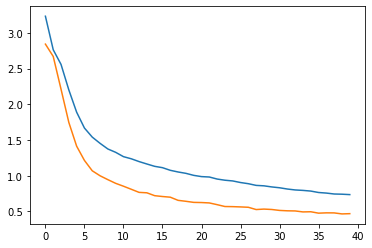

In [27]:
loss_tracker_train, loss_tracker_test = torch.load (save_path + "_loss_plot")

plt.plot (loss_tracker_train)
plt.plot (loss_tracker_test)
plt.show()

In [28]:
model.load_state_dict(torch.load(save_path))
if epoch is None:
  epoch = 1

In [29]:
test(model, device, test_loader, criterion, epoch, writer , complete_report=False)


evaluating...


preds: <j fa]qre b/]ese j ya]s mi.avad>
targets: <j faqr b/]ese ya]s mi.avad>
Test set: Average loss: 0.4100, Average CER: 0.112390 Average WER: 0.3968

preds: <j g/ra, ]is/lne ]aravade kxubi d/.t>
targets: <j g/r/[ ]ems/l dar/made xubi d/.t>
Test set: Average loss: 0.4751, Average CER: 0.138627 Average WER: 0.4646


